In [1]:
!git clone https://github.com/allanbil214/facerecog_lbp.git

Cloning into 'facerecog_lbp'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 416 (delta 18), reused 47 (delta 7), pack-reused 345
Receiving objects: 100% (416/416), 279.91 MiB | 37.19 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Updating files: 100% (248/248), done.


# Import libraries

In [2]:
import cv2
# import os untuk membaca data training directory dan path-nya
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm

# Deteksi Wajah
pengujian terhadap file gambar yang akan di training

In [3]:
# aktifkan path directori data untuk training dan testing
training_data_folder_path = '/content/facerecog_lbp/train'
test_data_folder_path = '/content/facerecog_lbp/test'

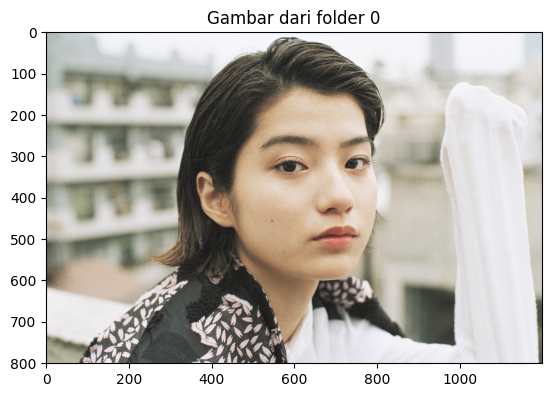

In [48]:
baca_gambar = cv2.imread('/content/facerecog_lbp/train/0/makita_24.jpg')
gambar=cv2.cvtColor(baca_gambar,cv2.COLOR_BGR2RGB)
plt.title('Gambar dari folder 0')
plt.imshow(gambar)

In [5]:
# load LBP opencv
lbpcascade_frontalface = '/content/facerecog_lbp/lbp/lbpcascade_frontalface_improved.xml'

In [6]:
# fungsi deteksi wajah pada opencv
def detek_wajah(input_gbr):
    # konversi gambar ke kabuan
    gbr = cv2.cvtColor(input_gbr, cv2.COLOR_BGR2GRAY)

    # klasifikasi cascade
    cascade_wajah = cv2.CascadeClassifier(lbpcascade_frontalface)

    # deteksi dengan multiscale
    wajah = cascade_wajah.detectMultiScale(gbr, scaleFactor=1.2, minNeighbors=5);

    #jika tidak ada wajah terdeteksi kembali ke gambar yang asli
    if (len(wajah) == 0):
        return None, None

    # ekstrak area wajah
    (x, y, w, h) = wajah[0]
    # kembalikan hanya bagian wajah dari gambar
    return gbr[y:y+w, x:x+h], wajah[0]

# Persiapan training data

In [7]:
def prepare_training_data(training_data_folder_path):
    # Lists to hold detected faces and their corresponding labels
    detected_faces = []
    labels = []

    # Get the list of subdirectories (each subdirectory represents a class)
    class_directories = [os.path.join(training_data_folder_path, dir_name) for dir_name in os.listdir(training_data_folder_path) if os.path.isdir(os.path.join(training_data_folder_path, dir_name))]

    # Initialize tqdm progress bar
    pbar = tqdm(total=len(class_directories), desc='Processing Images', unit='dir')

    # Traverse each class directory
    for class_dir in class_directories:
        # Extract label from directory name
        label = int(os.path.basename(class_dir))

        # Get the list of image files in the class directory
        image_files = [file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file)) and (file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'))]

        # Initialize tqdm progress bar for images in the current class directory
        pbar_images = tqdm(total=len(image_files), desc=f'Class {label}', unit='img', leave=False)

        # Traverse each image file in the class directory
        for image_file in image_files:
            # Read the image
            img = cv2.imread(os.path.join(class_dir, image_file))

            # Detect faces in the image
            face, _ = detek_wajah(img)

            # If face is detected, add it to the list along with its label
            if face is not None:
                detected_faces.append(face)
                labels.append(label)

            # Update tqdm progress bar
            pbar_images.update(1)

        # Close tqdm progress bar for images in the current class directory
        pbar_images.close()

        # Update tqdm progress bar
        pbar.update(1)

    # Close tqdm progress bar
    pbar.close()

    return detected_faces, labels


In [8]:
# siapkan data pelatihan
# data akan berada dalam dua daftar dengan ukuran yang sama
# satu daftar akan berisi semua wajah
# dan daftar lainnya akan berisi label masing-masing untuk setiap wajah
deteksi_wajah, label_wajah = prepare_training_data(training_data_folder_path)

Processing Images: 100%|██████████| 3/3 [00:51<00:00, 17.01s/dir]


In [9]:
# print total label dan wajah
print("Total wajah: ", len(deteksi_wajah))
print("Total label: ", len(label_wajah))

Total wajah:  80
Total label:  80


In [10]:
# buat pengenal wajah LBPH
lbphfaces_recognizer=cv2.face.LBPHFaceRecognizer_create(radius=1, neighbors=2)

# Inisiasi Pengenalan Wajah

In [11]:
# latih pengenalan wajah  dari wajah latihan
lbphfaces_recognizer.train(deteksi_wajah, np.array(label_wajah))

# Pelatihan model pengenalan wajah

In [12]:
# fungsi menggambar persegi  pada gambar
# sesuai dengan koordinat (x, y) yang diberikan dan diberikan lebar dan tinggi
def gambar_persegi(test_gambar, persegi):
    (x, y, w, h) = persegi
    cv2.rectangle(test_gambar, (x, y), (x+w, y+h), (0, 0, 255), 2)

# fungsi untuk menggambar teks pada memberikan gambar mulai dari #melewati (x, y) koordinat.
def gambar_text(test_gambar, label_text, x, y):
    cv2.putText(test_gambar, label_text, (x, y), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255, 255, 255), 2)

# Prediksi hasil dengan menggunakan test data

In [13]:
# fungsi untuk prediksi
def predict(test_gambar):
        # wajah input sama dengan wajah di data-training
    wajah_pilih, persegi = detek_wajah(test_gambar)
    # nama wajah yang sesuai katagori
    label= lbphfaces_recognizer.predict(wajah_pilih)
    # nama teks yang sesuai dengan label
    label_text = tags[label[0]]
    # membuat persegi dan teks di sekitar wajah
    gambar_persegi(test_gambar, persegi)
    gambar_text(test_gambar, label_text, persegi[0], persegi[1]-5)
    return test_gambar, label_text

In [38]:
tags = ['Makita', 'Riho', "Chalamet"]
test_gambar = cv2.imread('/content/facerecog_lbp/test/makita_1.jpg')
prediksi_gambar, label = predict(test_gambar)

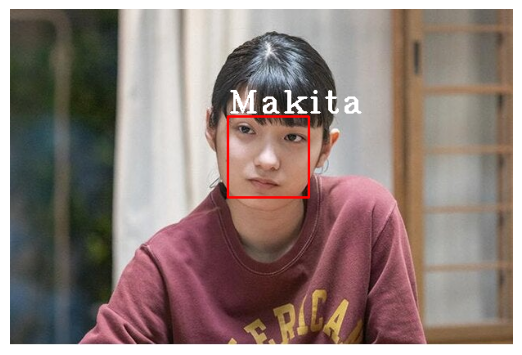

In [39]:
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
plt.axis("off")
imgplot = plt.imshow(cv2.cvtColor(prediksi_gambar, cv2.COLOR_BGR2RGB))
plt.show()

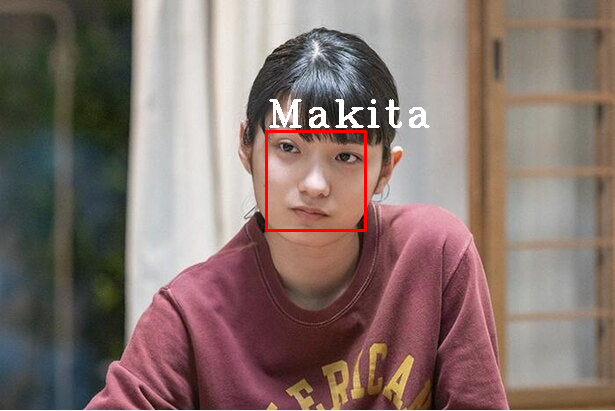

In [40]:
cv2_imshow(prediksi_gambar)